## XGBcard

### 模型

基于XGBoost算法的评分卡

### 功能

- 支持XGBoost直接生成评分卡；
- 支持基于XGBoost解析提升树分箱，并用于逻辑回归评分卡；
- 支持全流程自动生成评分卡，且支持各个模块单独使用和人工调整；

In [1]:
import toad
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

seed = 9853
np.random.seed(seed)

### 1 读取数据

In [2]:
data = pd.read_csv('./data/german_credit.csv')
data.rename(columns={'default':'creditability'},inplace=True)
data_info = toad.detector.detect(data)

### 2 数据预处理

#### 2.1 提取数值型和类别性变量

In [3]:
# 手动提取
targets = 'creditability'
nums_lst = data_info[data_info.type=='int64'].index.values
nums_lst = list(nums_lst[nums_lst!=targets])
cates_lst = list(data_info[data_info.type=='object'].index.values)

In [4]:
# 自动提取
from XGBcard.VarTypeClassify import VarTypeClassify

vtc = VarTypeClassify(data, exclude='creditability')
cates_lst, nums_lst = vtc.classifier()
targets = 'creditability'

#### 2.2 生成数据集

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('creditability',axis=1), 
                                                    data['creditability'], 
                                                    test_size=0.25, 
                                                    random_state=seed)

data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

#### 2.3 EDA

In [8]:
import base64
from IPython.core.display import display, HTML
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

proto = GenericFeatureStatisticsGenerator().ProtoFromDataFrames([{'name': 'train', 'table': data_train},
                                                                 {'name': 'test', 'table': data_test}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="/nbextensions/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

#### 2.4 类别型变量转化为数值型变量

- badrate
- woe

In [9]:
from XGBcard.CategoricalEncoder import CategoricalEncoder

CatEnc = CategoricalEncoder(encoding='badrate')
X_train_enc = CatEnc.fit_transform(X_train[cates_lst], y_train, cate_names=cates_lst)
X_train.loc[:, cates_lst] = X_train_enc
X_test_enc = CatEnc.transform(X_test[cates_lst])
X_test.loc[:, cates_lst] = X_test_enc

#### 2.5 生成数据集

In [ ]:
data_train_w = pd.concat([X_train, y_train], axis=1)
data_test_w = pd.concat([X_test, y_test], axis=1)
# 可引入样本权重，默认均为1
data_train_w['weight'] = 1
data_test_w['weight'] = 1

# 构建数据集
datasets = {'dev': data_train_w,
            'val': data_test_w}

### 3、变量初步筛选（可选）


重要度筛选

In [ ]:
from XGBcard.VarsFilter import VarsFilter
params = {}
model = VarsFilter(datasets, targets, 'weight', nums_lst+cates_lst, params, max_del_var_nums=2)
model.training(min_score=0.0115)

In [ ]:
X_train = X_train[model.var_names]
X_test = X_test[model.var_names]

### 4、自动调参

调节pos_weight，可引入代价敏感学习，加大对分错负样本的惩罚(1:0)

In [10]:
from XGBcard.AutoTuningParams import AutoTuningParams

atp = AutoTuningParams(X_train, y_train)
atp.auto_tuning()

Best accuracy score =  0.7607843137254902
Best parameters =  {'n_estimators': 1594, 'min_child_weight': 3, 'min_samples_split': 32, 'min_samples_leaf': 97, 'subsample': 1, 'colsample_bytree': 0.3053307126563066, 'reg_alpha': 2, 'reg_lambda': 15}


In [11]:
atp.model_eval(X_test, y_test)

-- Training Error --
F1: 0.4573
KS: 0.5426
AUC: 0.8437

-- Test Error --
F1: 0.3510
KS: 0.5474
AUC: 0.8232

-- Confusion Matrix --
Predicted    0   1  All
Actual                 
0          170  20  190
1           25  35   60
All        195  55  250


### 5、递归特征删除（可选）

In [ ]:
model.auto_delete_vars(atp.selected_params)

In [ ]:
X_train = X_train[model.var_names]
X_test = X_test[model.var_names]

### 6、构建评分卡模型

#### 6.1 训练模型

In [12]:
from XGBcard.ScoreCard import XGBcard

# 提升树显示特征名称
feature_names = list(X_train.columns)
XGBcard = XGBcard(X_train, y_train, X_test, y_test, feature_names=list(feature_names))
xgb_model = XGBcard.train(atp.selected_params)

[0]	train-auc:0.685417	test-auc:0.675877
[1]	train-auc:0.71009	test-auc:0.704167
[2]	train-auc:0.71009	test-auc:0.704167
[3]	train-auc:0.729097	test-auc:0.710351
[4]	train-auc:0.729097	test-auc:0.710351
[5]	train-auc:0.744649	test-auc:0.720789
[6]	train-auc:0.746258	test-auc:0.722018
[7]	train-auc:0.746258	test-auc:0.722018
[8]	train-auc:0.746258	test-auc:0.722018
[9]	train-auc:0.751761	test-auc:0.719912
[10]	train-auc:0.760584	test-auc:0.738465
[11]	train-auc:0.757038	test-auc:0.739956
[12]	train-auc:0.757038	test-auc:0.739956
[13]	train-auc:0.76252	test-auc:0.741404
[14]	train-auc:0.767304	test-auc:0.741491
[15]	train-auc:0.768056	test-auc:0.741228
[16]	train-auc:0.775609	test-auc:0.748684
[17]	train-auc:0.774583	test-auc:0.751842
[18]	train-auc:0.774191	test-auc:0.750263
[19]	train-auc:0.773864	test-auc:0.749035
[20]	train-auc:0.773864	test-auc:0.749035
[21]	train-auc:0.773538	test-auc:0.74886
[22]	train-auc:0.774273	test-auc:0.74693
[23]	train-auc:0.77402	test-auc:0.746842
[24]	tra

[194]	train-auc:0.818133	test-auc:0.806404
[195]	train-auc:0.818231	test-auc:0.80614
[196]	train-auc:0.818468	test-auc:0.805965
[197]	train-auc:0.818672	test-auc:0.806053
[198]	train-auc:0.818329	test-auc:0.80614
[199]	train-auc:0.818468	test-auc:0.806491
[200]	train-auc:0.818566	test-auc:0.806404
[201]	train-auc:0.818762	test-auc:0.80614
[202]	train-auc:0.818787	test-auc:0.807018
[203]	train-auc:0.81877	test-auc:0.807018
[204]	train-auc:0.818811	test-auc:0.807105
[205]	train-auc:0.818836	test-auc:0.807018
[206]	train-auc:0.819007	test-auc:0.80693
[207]	train-auc:0.819056	test-auc:0.806667
[208]	train-auc:0.819081	test-auc:0.807105
[209]	train-auc:0.819097	test-auc:0.807632
[210]	train-auc:0.81922	test-auc:0.807018
[211]	train-auc:0.819318	test-auc:0.807193
[212]	train-auc:0.81953	test-auc:0.807807
[213]	train-auc:0.819555	test-auc:0.80886
[214]	train-auc:0.819587	test-auc:0.808509
[215]	train-auc:0.819767	test-auc:0.808421
[216]	train-auc:0.819988	test-auc:0.808772
[217]	train-auc:0.8

[386]	train-auc:0.827937	test-auc:0.814211
[387]	train-auc:0.828019	test-auc:0.814211
[388]	train-auc:0.828051	test-auc:0.813947
[389]	train-auc:0.828117	test-auc:0.813947
[390]	train-auc:0.828158	test-auc:0.813947
[391]	train-auc:0.828288	test-auc:0.813947
[392]	train-auc:0.828378	test-auc:0.814035
[393]	train-auc:0.828264	test-auc:0.814035
[394]	train-auc:0.828207	test-auc:0.814211
[395]	train-auc:0.828305	test-auc:0.814211
[396]	train-auc:0.828362	test-auc:0.814035
[397]	train-auc:0.828337	test-auc:0.814123
[398]	train-auc:0.828411	test-auc:0.814123
[399]	train-auc:0.828444	test-auc:0.814474
[400]	train-auc:0.828566	test-auc:0.814737
[401]	train-auc:0.828566	test-auc:0.814737
[402]	train-auc:0.828468	test-auc:0.814298
[403]	train-auc:0.828566	test-auc:0.814737
[404]	train-auc:0.828648	test-auc:0.814649
[405]	train-auc:0.828689	test-auc:0.814649
[406]	train-auc:0.828779	test-auc:0.814737
[407]	train-auc:0.828852	test-auc:0.814737
[408]	train-auc:0.828868	test-auc:0.814825
[409]	train

[578]	train-auc:0.834551	test-auc:0.817018
[579]	train-auc:0.834583	test-auc:0.816579
[580]	train-auc:0.834534	test-auc:0.816316
[581]	train-auc:0.834616	test-auc:0.816491
[582]	train-auc:0.834526	test-auc:0.816579
[583]	train-auc:0.834592	test-auc:0.816667
[584]	train-auc:0.834641	test-auc:0.816842
[585]	train-auc:0.834649	test-auc:0.816842
[586]	train-auc:0.834747	test-auc:0.817105
[587]	train-auc:0.834788	test-auc:0.817281
[588]	train-auc:0.834739	test-auc:0.817193
[589]	train-auc:0.834763	test-auc:0.817281
[590]	train-auc:0.834804	test-auc:0.817193
[591]	train-auc:0.834828	test-auc:0.817281
[592]	train-auc:0.834812	test-auc:0.817456
[593]	train-auc:0.834845	test-auc:0.817281
[594]	train-auc:0.834869	test-auc:0.817105
[595]	train-auc:0.834943	test-auc:0.817193
[596]	train-auc:0.834902	test-auc:0.817456
[597]	train-auc:0.835	test-auc:0.817456
[598]	train-auc:0.83491	test-auc:0.817544
[599]	train-auc:0.834992	test-auc:0.817632
[600]	train-auc:0.835016	test-auc:0.817632
[601]	train-auc

[770]	train-auc:0.837761	test-auc:0.819211
[771]	train-auc:0.837753	test-auc:0.819211
[772]	train-auc:0.837778	test-auc:0.819211
[773]	train-auc:0.837819	test-auc:0.819123
[774]	train-auc:0.837859	test-auc:0.819123
[775]	train-auc:0.837892	test-auc:0.819123
[776]	train-auc:0.837892	test-auc:0.819035
[777]	train-auc:0.837909	test-auc:0.819123
[778]	train-auc:0.837892	test-auc:0.819035
[779]	train-auc:0.837851	test-auc:0.819035
[780]	train-auc:0.837917	test-auc:0.819035
[781]	train-auc:0.837958	test-auc:0.819035
[782]	train-auc:0.838031	test-auc:0.819123
[783]	train-auc:0.837982	test-auc:0.819035
[784]	train-auc:0.83799	test-auc:0.819123
[785]	train-auc:0.838023	test-auc:0.819035
[786]	train-auc:0.838023	test-auc:0.819035
[787]	train-auc:0.838015	test-auc:0.819035
[788]	train-auc:0.837998	test-auc:0.819298
[789]	train-auc:0.837982	test-auc:0.819211
[790]	train-auc:0.838015	test-auc:0.819211
[791]	train-auc:0.837974	test-auc:0.819298
[792]	train-auc:0.837998	test-auc:0.819298
[793]	train-

[962]	train-auc:0.840131	test-auc:0.821754
[963]	train-auc:0.840139	test-auc:0.821491
[964]	train-auc:0.840155	test-auc:0.821404
[965]	train-auc:0.840188	test-auc:0.821667
[966]	train-auc:0.840131	test-auc:0.821667
[967]	train-auc:0.840172	test-auc:0.821579
[968]	train-auc:0.840172	test-auc:0.821667
[969]	train-auc:0.840172	test-auc:0.821667
[970]	train-auc:0.840188	test-auc:0.821667
[971]	train-auc:0.840155	test-auc:0.821667
[972]	train-auc:0.840163	test-auc:0.821667
[973]	train-auc:0.840172	test-auc:0.821667
[974]	train-auc:0.840245	test-auc:0.821667
[975]	train-auc:0.84027	test-auc:0.821579
[976]	train-auc:0.840245	test-auc:0.821754
[977]	train-auc:0.840261	test-auc:0.821667
[978]	train-auc:0.840237	test-auc:0.821667
[979]	train-auc:0.840237	test-auc:0.821579
[980]	train-auc:0.840278	test-auc:0.821754
[981]	train-auc:0.840245	test-auc:0.821754
[982]	train-auc:0.840237	test-auc:0.821667
[983]	train-auc:0.840261	test-auc:0.821579
[984]	train-auc:0.840261	test-auc:0.821667
[985]	train-

[1150]	train-auc:0.841193	test-auc:0.822105
[1151]	train-auc:0.841209	test-auc:0.822105
[1152]	train-auc:0.841185	test-auc:0.822193
[1153]	train-auc:0.841176	test-auc:0.822193
[1154]	train-auc:0.84125	test-auc:0.822281
[1155]	train-auc:0.841234	test-auc:0.822368
[1156]	train-auc:0.841234	test-auc:0.822368
[1157]	train-auc:0.841274	test-auc:0.822456
[1158]	train-auc:0.841299	test-auc:0.822456
[1159]	train-auc:0.841291	test-auc:0.822456
[1160]	train-auc:0.841274	test-auc:0.822456
[1161]	train-auc:0.841283	test-auc:0.822368
[1162]	train-auc:0.841291	test-auc:0.822368
[1163]	train-auc:0.841315	test-auc:0.822456
[1164]	train-auc:0.841332	test-auc:0.822368
[1165]	train-auc:0.841324	test-auc:0.822456
[1166]	train-auc:0.841348	test-auc:0.822456
[1167]	train-auc:0.841364	test-auc:0.822368
[1168]	train-auc:0.841364	test-auc:0.822368
[1169]	train-auc:0.841364	test-auc:0.822368
[1170]	train-auc:0.841364	test-auc:0.822456
[1171]	train-auc:0.841364	test-auc:0.822544
[1172]	train-auc:0.841471	test-au

[1338]	train-auc:0.842537	test-auc:0.823684
[1339]	train-auc:0.842549	test-auc:0.823684
[1340]	train-auc:0.842516	test-auc:0.823596
[1341]	train-auc:0.842533	test-auc:0.823596
[1342]	train-auc:0.842508	test-auc:0.823596
[1343]	train-auc:0.842533	test-auc:0.823596
[1344]	train-auc:0.842541	test-auc:0.823509
[1345]	train-auc:0.842516	test-auc:0.823509
[1346]	train-auc:0.842516	test-auc:0.823421
[1347]	train-auc:0.842467	test-auc:0.823509
[1348]	train-auc:0.842508	test-auc:0.823509
[1349]	train-auc:0.842533	test-auc:0.823509
[1350]	train-auc:0.842516	test-auc:0.823509
[1351]	train-auc:0.842541	test-auc:0.823509
[1352]	train-auc:0.842525	test-auc:0.823509
[1353]	train-auc:0.842574	test-auc:0.823509
[1354]	train-auc:0.842614	test-auc:0.823509
[1355]	train-auc:0.842582	test-auc:0.823421
[1356]	train-auc:0.842557	test-auc:0.823421
[1357]	train-auc:0.842565	test-auc:0.823421
[1358]	train-auc:0.842598	test-auc:0.823421
[1359]	train-auc:0.842557	test-auc:0.823421
[1360]	train-auc:0.842565	test-a

[1525]	train-auc:0.843382	test-auc:0.823333
[1526]	train-auc:0.843382	test-auc:0.823333
[1527]	train-auc:0.843415	test-auc:0.823158
[1528]	train-auc:0.843325	test-auc:0.823333
[1529]	train-auc:0.84335	test-auc:0.823333
[1530]	train-auc:0.843399	test-auc:0.823246
[1531]	train-auc:0.84344	test-auc:0.823246
[1532]	train-auc:0.843456	test-auc:0.82307
[1533]	train-auc:0.843489	test-auc:0.82307
[1534]	train-auc:0.843464	test-auc:0.82307
[1535]	train-auc:0.84344	test-auc:0.82307
[1536]	train-auc:0.843464	test-auc:0.823158
[1537]	train-auc:0.84344	test-auc:0.823158
[1538]	train-auc:0.843448	test-auc:0.823158
[1539]	train-auc:0.843472	test-auc:0.823158
[1540]	train-auc:0.843464	test-auc:0.823158
[1541]	train-auc:0.843497	test-auc:0.823158
[1542]	train-auc:0.843489	test-auc:0.823246
[1543]	train-auc:0.843529	test-auc:0.823158
[1544]	train-auc:0.843497	test-auc:0.823158
[1545]	train-auc:0.843497	test-auc:0.823246
[1546]	train-auc:0.843513	test-auc:0.823246
[1547]	train-auc:0.843497	test-auc:0.823

In [13]:
XGBcard.eval()

-- Training Evaluation --
AUC: 0.7190
KS: 0.5426
ACC: 0.7813
Recall: 0.5458
F1-score: 0.6150
Precesion: 0.7043
Confusion Matrix: 
 [[455  55]
 [109 131]]

-- Test Evaluation --
AUC: 0.7390
KS: 0.5474
ACC: 0.8200
Recall: 0.5833
F1-score: 0.6087
Precesion: 0.6364
Confusion Matrix: 
 [[170  20]
 [ 25  35]]


#### 6.2 计算评分

**评分区间300-850（分数越高，风险越小）：PDO = 40, 600 = 10:1 odds**

In [14]:
PDO = 40
odds = 0.1
base_score = 600
B = PDO/np.log(2)
A = base_score + B*np.log(odds)

A - B*np.log(10)

334.24575240901095

In [15]:
# Train Evaluation
EYtr_proba = xgb_model.predict(XGBcard.dtrain)
EYtr_score = XGBcard.scoring(EYtr_proba)
# Test Evaluation
EYts_proba = xgb_model.predict(XGBcard.dtest)
EYts_score = XGBcard.scoring(EYts_proba)

print('max score: ', EYts_score.max())
print('min score: ', EYts_score.min())

max score:  732
min score:  353


#### 6.3 生成评分卡

In [16]:
XGBcard.score_card(cates_lst, CatEnc.cates_badrate)

,features,num_box,box,value,pred,score
0,BASE_SCORE,None,None,NaN,NaN,467.122876
0,account_check_status,<0.189340502,no checking account,-1.283627,0.216933,74.000000
1,account_check_status,"[0.189340502,0.343253493]",>= 200 DM / salary assignments for at least 1 ...,-0.571419,0.360909,32.000000
2,account_check_status,"[0.343253493,0.465346515]",0 <= ... < 200 DM,0.070489,0.517615,-4.000000
3,account_check_status,>0.465346515,< 0 DM,0.251366,0.562513,-14.000000
4,age,<25.5,<25.5,0.302807,0.575128,-17.000000
5,age,"[25.5,26.5]","[25.5,26.5]",0.166221,0.541460,-9.000000
6,age,"[26.5,34.5]","[26.5,34.5]",-0.036914,0.490773,2.000000
7,age,"[34.5,35.5]","[34.5,35.5]",-0.133285,0.466728,7.000000
8,age,>35.5,>35.5,-0.205200,0.448879,11.000000


#### 6.4 提取提升树分箱

提升树分箱可用于逻辑回归

In [17]:
features_bin = XGBcard.features_bin
features_bin

defaultdict(list,
            {'account_check_status': [['no checking account'],
              ['>= 200 DM / salary assignments for at least 1 year'],
              ['0 <= ... < 200 DM'],
              ['< 0 DM']],
             'age': [25.5, 26.5, 34.5, 35.5],
             'credit_amount': [605.0,
              653.0,
              683.5,
              959.5,
              1286.0,
              1373.0,
              1388.5,
              2246.5,
              2824.0,
              3554.0,
              3909.5,
              5024.0,
              6719.5,
              7480.5,
              10841.5],
             'credit_history': [['critical account/ other credits existing (not at this bank)'],
              ['existing credits paid back duly till now'],
              ['delay in paying off in the past'],
              ['all credits at this bank paid back duly',
               'no credits taken/ all credits paid back duly']],
             'duration_in_month': [8.5, 11.5, 15.5, 26.5, 31.5]

### 7、模型评估和监控

- `metric`模块

#### 7.1 模型效果

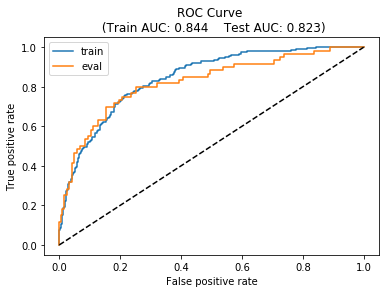

In [19]:
from XGBcard.Metrics import plot_roc_curve, plot_ks_curve, plot_divergence

Ytr_prob = xgb_model.predict(XGBcard.dtrain)
Yts_prob = xgb_model.predict(XGBcard.dtest)

plot_roc_curve(y_train, Ytr_prob, co_labels=y_test, co_preds=Yts_prob)

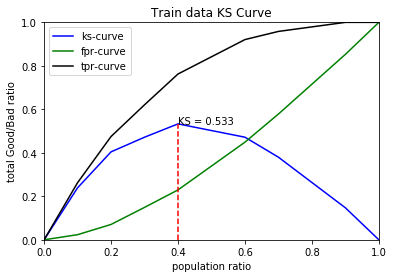

In [20]:
plot_ks_curve(y_train, Ytr_prob, title='Train data KS Curve')

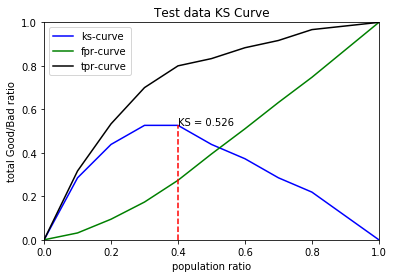

In [21]:
plot_ks_curve(y_test, Yts_prob, title='Test data KS Curve')

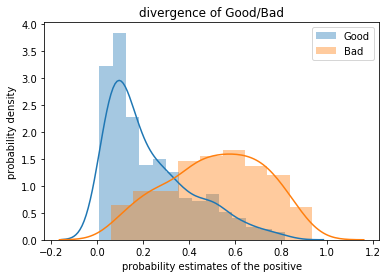

In [22]:
plot_divergence(y_train, Ytr_prob, plot_type='dist')

#### 7.2 稳定性

- 模型PSI
- 变量PSI

In [23]:
from XGBcard.Utils import PSI_nums, PSI_cates

# 模型PSI
print('训练集和测试集预测结果的PSI：', PSI_nums(Ytr_prob, Yts_prob))

# 变量PSI
print('训练集和测试集特征duration_in_month的PSI：', PSI_nums(X_train.duration_in_month.values, X_test.duration_in_month.values))

训练集和测试集预测结果的PSI： 0.05160013935185666
训练集和测试集特征duration_in_month的PSI： 0.05298897011693567


#### 7.3 模型报告

In [24]:
from XGBcard.Metrics import report

df_report = report(y_test.values, EYts_score, bins=10, bin_type='cut')
df_report

,bins,bin_cnt,good,bad,good_cnt,bad_cnt,good_pctg,bad_pctg,bad_rate,ks
0,"(352.62, 390.9]",3,0,3,0,3,0.00,0.05,1.000,0.05
1,"(390.9, 428.8]",18,5,13,5,16,0.03,0.27,0.722,0.24
2,"(428.8, 466.7]",34,15,19,20,35,0.11,0.58,0.559,0.47
3,"(466.7, 504.6]",41,28,13,48,48,0.25,0.80,0.317,0.55
4,"(504.6, 542.5]",46,43,3,91,51,0.48,0.85,0.065,0.37
5,"(542.5, 580.4]",31,27,4,118,55,0.62,0.92,0.129,0.30
6,"(580.4, 618.3]",30,27,3,145,58,0.76,0.97,0.100,0.21
7,"(618.3, 656.2]",26,24,2,169,60,0.89,1.00,0.077,0.11
8,"(656.2, 694.1]",17,17,0,186,60,0.98,1.00,0.000,0.02
9,"(694.1, 732.0]",4,4,0,190,60,1.00,1.00,0.000,0.00


#### 7.4 表现报告

- ks-badrate
- bin_cnt-badrate
- badrate_pred-badrate_actual
- 预测和实际的客户分数分布
- 开发样本和实际样本的特征分布

In [26]:
from XGBcard.Metrics import plot_chart

plot_chart(df_report, legend='bins', plot_lst=['ks', 'bad_rate'], plot_type=['line', 'line'])

In [27]:
plot_chart(df_report, legend='bins', plot_lst=['bin_cnt', 'bad_rate'], plot_type=['bar', 'line'])

### 8、提升树分箱直接用于逻辑回归评分卡

In [28]:
data = pd.read_csv('./data/german_credit.csv')
data.rename(columns={'default':'creditability'},inplace=True)
data_info = toad.detector.detect(data)

In [29]:
Xtr,Xts,Ytr,Yts = train_test_split(data.drop('creditability',axis=1), data['creditability'],
                                   test_size=0.25, random_state=450)
data_tr = pd.concat([Xtr,Ytr],axis=1)

#增加一列区分训练/测试的特征
data_tr['type'] = 'train'
data_ts = pd.concat([Xts,Yts],axis=1)
data_ts['type'] = 'test'

#### 8.1 粗筛选

In [30]:
selected_data, drop_lst= toad.selection.select(data_tr,target = 'creditability', empty = 0.5, iv = 0.05, corr = 0.7, return_drop=True, exclude=['type'])
selected_test = data_ts[selected_data.columns]
print(selected_data.shape)
print(drop_lst)

(750, 16)
{'empty': array([], dtype=float64), 'iv': array(['installment_as_income_perc', 'present_res_since',
       'credits_this_bank', 'job', 'people_under_maintenance',
       'telephone'], dtype=object), 'corr': array([], dtype=object)}


#### 8.2 提升树分箱&WOE转化

In [31]:
# 使用提升树分箱
adj_bin = features_bin

# 初始化一个combiner类
combiner = toad.transform.Combiner()
combiner.set_rules(adj_bin)

#将特征的值转化为分箱的箱号。
binned_data = combiner.transform(selected_data)

#计算WOE
transer = toad.transform.WOETransformer()

#对WOE的值进行转化，映射到原数据集上。对训练集用fit_transform,测试集用transform.
data_tr_woe = transer.fit_transform(binned_data, binned_data['creditability'], exclude=['creditability','type'])
data_ts_woe = transer.transform(combiner.transform(selected_test))

#### 8.3 特征选择

In [32]:
final_data = toad.selection.stepwise(data_tr_woe.drop('type',axis=1), target = 'creditability', direction = 'both', criterion = 'aic')

final_test = data_ts_woe[final_data.columns]
print(final_data.shape)
print(final_data.columns)

(750, 9)
Index(['account_check_status', 'duration_in_month', 'credit_history',
       'purpose', 'credit_amount', 'savings', 'personal_status_sex',
       'other_installment_plans', 'creditability'],
      dtype='object')


#### 8.4 建模

In [33]:
from sklearn.linear_model import LogisticRegression

Xtr = final_data.drop('creditability',axis=1)
Ytr = final_data['creditability']
Xts = final_test.drop('creditability',axis=1)
Yts = final_test['creditability']

lr = LogisticRegression(class_weight='balanced', C=0.1)
lr.fit(Xtr, Ytr)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### 8.5 评估

In [34]:
from toad.metrics import KS, F1, AUC
from sklearn import metrics

EYtr_proba = lr.predict_proba(Xtr)[:,1]
EYtr = lr.predict(Xtr)

print('Training error')
print('F1:', F1(EYtr_proba,Ytr))
print('KS:', KS(EYtr_proba,Ytr))
print('AUC:', AUC(EYtr_proba,Ytr))

EYts_proba = lr.predict_proba(Xts)[:,1]
EYts = lr.predict(Xts)

print('\nTest error')
print('F1:', F1(EYts_proba,Yts))
print('KS:', KS(EYts_proba,Yts))
print('AUC:', AUC(EYts_proba,Yts))

metrics.confusion_matrix(Yts, EYts)

Training error
F1: 0.4588477366255144
KS: 0.5314308336351614
AUC: 0.8258690543374803

Test error
F1: 0.44859813084112155
KS: 0.5490287129479142
AUC: 0.8205634238836003


array([[133,  44],
       [ 19,  54]], dtype=int64)

**结论：**  
使用卡方分箱，KS值只能达到0.47左右，使用提升树分箱可以直接提升到0.54左右，提升效果比较明显。